# $$ \text{Projet rupture de barrage - MU4MEF04} $$

$$\textit{DUVIVIER Valentin} - \textit{ROLLAND Raphaël} - MF2A/CompMech $$

$ $

$ $

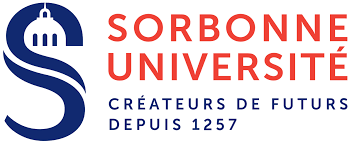

$ $

$ $

## Données générales

#### Librairies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
%matplotlib inline

#### Maillage

In [ ]:
### Numerical parameters

## space variables

# number of points to define the mesh
N   = 400

# length of the mesh
L   = 10.

# Spatial grid
x   = np.zeros(N+2)
dx  = L/len(x)

for i in range(len(x)):
    x[i] = (i - N / 2) * dx

# --------------------------------------------------------

## time data

t0  = 0.
T   = .05

dt  = 0.001

# --------------------------------------------------------

## constant
g   = 1. #adimensionalisation

CFL = dt/dx
CFL

##### fonctions $\eta$

In [ ]:
def eta0_dam(x, H0, center):    
    
    """  Discontinuous initial condition - dam like shape """
    
    # Data    
    eta_0 = np.zeros((len(x)))
    eta_0 = 0. + H0*(x<center)
    
    return eta_0

def eta0_dam_wet(x, H0, H1, center):    
    
    """  Discontinuous initial condition - dam like shape """
    
    # Data    
    eta_0 = np.zeros((len(x)))
    eta_0 = H1 + H0*(x<center)
    
    return eta_0

##### fonctions f

In [ ]:
# Different possible bottom

def gaussian_bump(x, B0, sig, origin):

    """ Gaussian function, equivalent to a bump at the bottom """
    
    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))

    # ---------------------------------------------

    # functions
    f  = B0*np.exp(-((x - origin)**2)/(2*sig**2))
    df = (- B0 * (x - origin)/(sig**2)) * np.exp(-((x - origin)**2)/(2*sig**2))
    
    return (f, df)


def slope_bump(x):
    
    """ Rectangular bump function """

    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # Data
    L     = 2*x[-1] # length mesh
    slope = .05
    
    # ---------------------------------------------
    
    # functions
    f  = slope*x
    df = np.linspace(slope, slope, len(x))
    
    return (f, df)

def no_bump(x):
    
    """ No bump function """
    
    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # ---------------------------------------------
    
    # functions
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))

    return (f, df)

def one_bump(x):
    
    """ Elevated bottom function """

    # Initialisation
    f  = np.ones((len(x)))
    df = np.zeros((len(x)))
    
    return (f, df)

##### Terme source S

In [ ]:
def S(u, x, f, mu, rho, g, eps):

    """ Shear stress + Topology """
    
    # Splitting vector
    h = u[:,0].copy()
    q = u[:,1].copy()
    
    # -------------------------------------------------------------
    
    ## Initialisation
    tau = np.zeros((len(h), 2)) #len(h)=len(x)
    Bx  = np.zeros((len(h), 2)) #len(h)=len(x)
    df  = np.zeros((len(x)))

    # -------------------------------------------------------------
    
    # Data
    L  = 2*x[-1]
    dx = L/len(x)
    
    # -------------------------------------------------------------
    
    ## Shearing coeff - Topology
    
    idx = (np.abs(h) > eps)

    tau[idx,1] = mu*3*q[idx]/h[idx]**2
    df[1:-1]   = (f[2:] - f[:-2])/(2*dx)
    
    Bx[idx, 1] = g*h[idx]*df[idx]

    ## Right hand side vector S
    S = -Bx - tau/rho

    return S

##### Vecteur de flux

In [ ]:
def fill_F(U, g, eps):
    
    """  Fill flux vector of equations """
    
    F = np.zeros_like((U))   
    
    # -------------------------------
    
    idx = (np.abs(U[:,0])>eps)
    
    # -------------------------------
    
    F[idx,0] = U[idx,1]
    F[idx,1] = U[idx,1]**2/U[idx,0] + (1/2)*g*U[idx,0]**2
    
    return F

# ---------------------------------------------------------------------------------------------------------------------

def fill_F_HLL_RUS(F, U, g, eps):
    
    """  Fill Flux vector of equations """
    
    idx = (np.abs(U[:,0])>eps)
    
    # -------------------------------

    # fluxes
    F_HLL = np.zeros_like(F)
    
    # velocities
    S_L = np.zeros(U.shape)    
    S_R = np.zeros(U.shape)
    
    # velocities
    S_L[idx,0] = S_L[idx,1] = U[idx,1]/U[idx,0] - np.sqrt(g*U[idx,0])
    S_L[:-1,:] = np.minimum(S_L[:-1,:], S_L[1:,:])
    
    S_R[idx,0] = S_R[idx,1] = U[idx,1]/U[idx,0] + np.sqrt(g*U[idx,0])
    S_R[:-1,:] = np.maximum(S_R[:-1,:], S_R[1:,:])
    
    # u = [h; q]
    U_R = U.copy()
    U_R[:-1,:] = U[1:,:]
    
    # --------------------------
    
    # fluxes
    F_L = F.copy()   
    F_R = F.copy()
    F_R[:-1,:] = F[1:,:]

    F_HLL[S_L>=0] = F_L[S_L>=0]
    F_HLL[S_R<=0] = F_L[S_R<=0]
    F_HLL[(S_R>0)&(S_L<0)] = ((S_R*F_L - S_L*F_R + S_L*S_R*(U_R - U))[(S_R>0)&(S_L<0)])/(S_R-S_L)[(S_R>0)&(S_L<0)]
    
    return F_HLL

# ---------------------------------------------------------------------------------------------------------------------

def BC(U):
    
    """  Boundary conditions """
    
    # Height
    U[0,0]  = U[1,0]
    U[-1,0] = U[-2,0]
    
    # Flux
    U[0,1]  = U[1,1]
    U[-1,1] = U[-2,1] #2*U[-2,1]-U[-3,1]
    
    return U

#### Solveur

In [ ]:
# Matrix/Operator version

import scipy.sparse as sp

# --------------------------------------------------------

def diverg_up_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [0, 1], (m, m)).toarray()
    
    Div[0,1] = 0
    Div[0,0] = Div[-1,-1] = 1
    
    return Div

def diverg_down_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [-1, 0], (m, m)).toarray()
    
    Div[-1,-2] = 1
    
    return Div

# --------------------------

def FR1(ug, ud, hg, hd):
     
    """ Rusanov numerical flux for height """

    c = np.maximum(abs(ug) + np.sqrt(hg), abs(ud) + np.sqrt(ud))
    
    return (hg*ug + hd*ud) * 0.5 - c*(hd-hg) * 0.5  # Numerical flux (mean - correction)


def FR2(ug, ud, hg, hd):
    
    """ Rusanov numerical flux for movement qtty """
    
    c = np.maximum(abs(ug) + np.sqrt(hg), abs(ud)+np.sqrt(ud))
    
    return (ug*ug*hg + hg*hg/2. + ud*ud*hd + hd*hd/2.) * 0.5 - c*(hd*ud - hg*ug)*0.5

# --------------------------

## Algo

def q_MC(x, dx, t0, T, dt, u_ini, f, g, rho, mu, eps, modulo):

    """  The MacCormak method """
        
    ## Method 1 - Finite volume - Rusanov flux with corection
    
    # Height
    h      = np.zeros(N+2)                   # height to solve system    
    h      = u_ini[:,0]                      # h variable
    h1     = [u_ini[:,0].copy()]             # variable to stock h over time

    # Speed
    u      = np.zeros(N+2)                   # speed to solve system
    u1     = [u_ini[:,1]/u_ini[:,0].copy()]  # variable to stock speed over time
    
    # Flow rate
    q      = np.zeros(N+2)                   # flux vector
    
    # Flux
    fp     = np.zeros(N+2)
    fd     = np.zeros(N+2)
    
    # -------------------------
    
    ## Method 2 - MacCormack - HLL flux
    
    # Speed
    U      = u_ini.copy()                    # speed to solve system

    # Height
    h2    = [u_ini[:,0].copy()]              # variable to stock height vector over time 
    
    # Flow rate
    q2    = [u_ini[:,1].copy()]              # variable to stock flux vector over time 
    
    # -------------------------------------------
    
    # Operator divergence for method 2
    Div_down = diverg_down_op(len(U[:,0]))
    Div_up   = diverg_up_op(len(U[:,0]))
    
    # -------------------------------------------
    
    ## Solving data
    npas   = int((T-t0)/dt)
    t      = t0                              # time begin study
    k      = 0                               # iterations
    
    while k < npas-1:
        
        k += 1
        t += dt
        
        ## Method 1 - Finite volume - Rusanov flux with corection

        fp[1:] = FR1(u[:-1], u[1:], h[:-1], h[1:]) # 1: == i
        fd[1:] = FR2(u[:-1], u[1:], h[:-1], h[1:])
        
        # avancee pour h, si h>0 avancee pour u      
        
        hn     = h[:-1] - dt*(fp[1:] - fp[:-1])/dx # 1: == i+1

        idx    = np.where(h>0.)
        ind    = idx[0][:-1]
        ind_1  = idx[0][1:]

        q[ind] = h[ind]*u[ind] - dt*(fd[ind_1] - fd[ind])/dx
        u[ind] = q[ind] / hn[ind]
        h[:-1] = hn
        
        # neumann condition in 0 & N
        h[0]   = h[1]
        u[0]   = u[1]
        
        h[-1]  = h[-2]
        u[-1]  = u[-2]
        
        if (k % modulo)==0:     # We only take some values (every a in i%a)
            h1.append(h.copy()) # vector containing h(x,T) for each iteration            
            u1.append(u.copy()) # vector containing u(x,T) for each iteration            
        
        # ------------------------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------------------------
           
        ## Method 2 - MacCormack - HLL flux
            
        # predictor solution
        F      = fill_F(U, g, eps)
        F_HLL  = fill_F_HLL_RUS(F, U, g, eps)
        u_star = U - (dt/dx)*Div_up@F_HLL + dt*S(U, x, f, mu, rho, g, eps)
        
        # Periodic BCs:
        BC(u_star)
        
        # ------------------------------------------------------------------------------------------------
        
        # corrector solution
        F_star      = fill_F(u_star, g, eps)
        F_HLL_star  = fill_F_HLL_RUS(F_star, u_star, g, eps)
        unew        = .5*(U+u_star) - .5*(dt/dx)*Div_down@F_HLL_star + dt*S(u_star, x, f, mu, rho, g, eps)
        
        # Periodic BCs:
        BC(unew)
        
        if (k % modulo)==0:             # We only take some values (every a in i%a)
            h2.append(unew[:,0].copy()) # vector containing h(x,T) for each iteration
            q2.append(unew[:,1].copy()) # vector containing q(x,T) for each iteration
        
        U = unew.copy()                 # vector containing u(x,T)
        
    return h1, u1, h2, q2

##### Initialisation

In [ ]:
## Chose bottom

# Data bump

# Height
B0     = 5.0

# Width
sig    = .5

# Origin
origin = L/2

(B, Bx) = no_bump(x)

# --------------------------------------------

## Choose initial state

H0   = 2              # height dam
cent = 0              # center dam # where rupture takes place

c0   = np.sqrt(g*H0)  # speed caracteristic

# Initial eta
eta0 = eta0_dam(x, H0, cent).reshape(-1,1)
f    = B.reshape(-1,1)

# Initial height
h0   = f
h0   = (eta0 - f)*(eta0>f)

# Initial flux
q0   = np.zeros((len(x)))
q0   = q0.reshape(-1, 1)

# Concatenation
u_ini = np.append(h0, q0, axis=1)

#### Résolution du système

In [ ]:
# Data
mu  = 10**-3 #[Pa.s]    # water dynamic viscosity
rho = 10**3  #[kg.m-3]  # water volumic mass

# Precision over height
eps = 10**-1

# keep value every modulo iterations
modulo = 10

T = 5.

# --------------------------------------------

# vector time
iterations = int((T-t0)/dt/modulo)
t = np.zeros((iterations))
for k in range(1, iterations):
    t[k] = t[k-1] + modulo*dt

# --------------------------------------------

# Height and flux
h1, u1, h2, q2 = q_MC(x, dx, t0, T, dt, u_ini, B, g, rho, mu, eps, modulo)

q1 = np.asarray(h1)*np.asarray(u1)
q1 = q1.tolist()

##### Solution exacte

In [ ]:
def sol_exact(x):
    
    """ Exact solution - height and speed """
    
    h_exact = np.zeros((N+2))
    hh      = [u_ini[:,0].copy()] # hh variable

    u_exact = np.zeros((N+2))
    uu      = [u_ini[:,1]/u_ini[:,0].copy()] # uu variable

    nt = int(T/dt)
    t  = 0
    
    H0 = 2
    U0 = 0
    
    for i in range(1, nt-1):
        
        t += dt
        
        h_exact = (1/g) * (H0 * ((x-0) <= -t*np.sqrt(g*H0)) + ((x-0) > -t*np.sqrt(g*H0)) * (2./3 * (np.sqrt(g*H0) - (x - 0)/(2*t)))**2) * (((x - 0) <= 2*t*np.sqrt(g*H0)))# + B*(x>0)
        u_exact = U0 * ((x-0) <= -t*c0) + ((x-0) > -t*c0) * (2./3. * ((x - cent)/t + c0)) * (((x - 0) <= 2*t*c0))
        
        if (i % modulo)==0: #We only take some values (every a in i%a)
            hh.append(h_exact)
            uu.append(u_exact)
         
    return hh, uu

hexact, uexact = sol_exact(x)


#### Solution linéarisée

In [ ]:
H0    = 2.
U_ini = np.array([H0*(x<0), np.zeros((N+2))])

# ------------------------------------------

def sol_lin(t0, U_ini, x):
    
    """ Exact solution - height and speed """
    
    h_lin   = np.zeros((N+2))
    q_lin   = np.zeros((N+2))

    stock_h = [U_ini[0].copy()]            # stock h
    stock_q = [U_ini[1].copy()]            # stock h

    Nt      = int(T/dt)                      # nb iteration
    t       = t0                             # initial time
    
    H0      = 2                              # initial height
    U0      = 0                              # initial speed
    
    c0      = np.sqrt(g*H0)
    
    # Eigen values
    lam1    = U0 + np.sqrt(g*H0)
    lam2    = U0 - np.sqrt(g*H0)

    # ----------------------------------------------------
    
    for i in range(1, Nt-1):
        
        t += dt
        
        h_lin = (1 / (lam2 - lam1)) * (lam2 * (H0*(x-c0*t<0)) - lam1 * (H0*(x+c0*t<0)))
        q_lin = (1 / (lam2 - lam1)) *  lam2 * lam1 * ( (H0*(x-c0*t<0)) - (H0*(x+c0*t<0)))
        
        if (i % modulo)==0:       # We only take some values (every a in i%a)
            stock_h.append(h_lin)
            stock_q.append(q_lin)
         
    return stock_h, stock_q

# ------------------------------------

h_lin, q_lin = sol_lin(0, U_ini, x)

u_lin = np.asarray(q_lin)/np.asarray(h_lin)
u_lin = u_lin.tolist()

#### Animation - Height - Model vs Numeric

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(hexact)[0])

fig   = plt.figure(figsize=(10,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h
line2, = ax.plot([], [], '--', color='orange', linewidth=2)  # Line plot for B
line3, = ax.plot([], [], 'r--', linewidth=2)  # Line plot for u
line4, = ax.plot([], [], 'g--', linewidth=2)  # Line plot for u
line5, = ax.plot([], [], '--', color='brown', linewidth=2)   # Line plot for B

#
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])

    #line.set_data([], [])
    time_text.set_text('')
    return [line1, line2, line3],
#

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis([-2 - .2, 2 + .2, -1, 3])              # Set the bounds of the plot

def animate(n):
    line1.set_data(x,     h1[n])
    line2.set_data(x,      B   )
    #line3.set_data(x,     h2[n])
    line4.set_data(x, hexact[n])
    line5.set_data(x, h_lin[n])
    
    time_text.set_text(str(round(n*modulo*dt, 3)) + ' s')    # don't forget to multiply by modulo

    return tuple([line1, line2, line3, line4, line5]) + tuple([time_text]) # [line1, line2, line3]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=n)  # Animate the solution

plt.legend(['h1', 'B', 'h2', 'h exact', 'h_lin'], loc=3)
plt.grid('True')

#plt.show()
HTML(anim.to_jshtml())

In [ ]:
# Graph

k  = 400

plt.figure(figsize=(8,4))                             # Create an empty figure

plt.plot(x, h1[k][:], 'b-', linewidth=2)                  # Line plot for q
plt.plot(x,  B   , '--', color='orange', linewidth=2)                  # Line plot for q
plt.plot(x, hexact[k][:], 'g--', linewidth=2)                  # Line plot for q
plt.plot(x, h_lin[k][:], '--', color='brown', linewidth=2)                  # Line plot for q

plt.title(f'Rupture de barrage - t = {modulo*dt*k:.2f} s')
plt.xlabel('x [m]')
plt.ylabel('h(x,t)')

plt.axis([-L/2 - .2, L/2 + .2, -1, 3])                       # Set the bounds of the plot

plt.legend(['h', 'B', 'h_lin'], loc=3)
plt.grid('True')

# ---------------------------------

#plt.savefig('Figures/db_lin4.png')

#### Animation - Speed - Model vs Numeric

In [ ]:

import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(u1)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h+B
line2, = ax.plot([], [], 'r-', linewidth=2)  # Line plot for u
line3, = ax.plot([], [], '--', color='purple', linewidth=2)  # Line plot for u exact

#
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])

    #line.set_data([], [])
    time_text.set_text('')
    return [line1, line2, line3],
#

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((-L/2 - .2, L/2 + .2, -1, 5))              # Set the bounds of the plot

def animate(n):
    line1.set_data(x, h1[n])
    line2.set_data(x, u1[n])
    line3.set_data(x, uexact[n])
    
    time_text.set_text(str(round(n*modulo*dt, 3)) + ' s')    # don't forget to multiply by modulo

    return tuple([line1, line2, line3]) + tuple([time_text]) # [line1, line2, line3]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=n)  # Animate the solution

plt.legend(['h+B', 'u', 'u exact'], loc=3)
plt.grid('True')

#plt.show()
HTML(anim.to_jshtml())


In [ ]:
# Graph

k  = 60

plt.figure(figsize=(8,4))                             # Create an empty figure

plt.plot(x, h1[k][:], 'b-', linewidth=2)  # Line plot for h+B
plt.plot(x, u1[k][:], 'r-', linewidth=2)  # Line plot for u
plt.plot(x, uexact[k][:], '--', color='purple', linewidth=2)  # Line plot for u exact

plt.title(f'Rupture de barrage - t = {modulo*dt*k:.2f} s')
plt.xlabel('x [m]')
plt.ylabel('h(x,t)')

plt.axis([-L/2 - .2, L/2 + .2, -1, 3])                       # Set the bounds of the plot

plt.legend(['h', 'u', 'uexact'], loc=3)
plt.grid('True')

# ---------------------------------

#plt.savefig('Figures/vsec4.png')

#### Animation - x/t - Model

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(hexact)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for hexact+B
line2, = ax.plot([], [], 'r-', linewidth=2)  # Line plot for uexact
line3, = ax.plot([], [], 'g--', linewidth=2)  # Line plot for x/t
line4, = ax.plot([], [], 'y--', linewidth=2)  # Line plot for 2c0
line5, = ax.plot([], [], '--', color = 'pink', linewidth=2)  # Line plot for -c0

#
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])

    #line.set_data([], [])
    time_text.set_text('')
    return [line1, line2, line3],
#

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((-L/2 - .2, L/2 + .2, -3, 3))              # Set the bounds of the plot

def animate(n):
    line1.set_data(x, (hexact+B)[n])
    line2.set_data(x, uexact[n])
    line3.set_data(x, x/t[n])
    line4.set_data(x, 2*c0)
    line5.set_data(x, -c0)
    
    time_text.set_text(str(round(n*modulo*dt, 3)) + ' s')    # don't forget to multiply by modulo

    return tuple([line1, line2, line3, line4, line5]) + tuple([time_text]) # [line1, line2, line3]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=n)  # Animate the solution

plt.legend(['hexact+B', 'uexact', 'x/t', '2c0', '- c0'], loc=3)
plt.grid('True')

#plt.show()
HTML(anim.to_jshtml())

In [ ]:
# Graph

k  = 142

plt.figure(figsize=(8,4))                             # Create an empty figure

plt.plot(x, hexact[k][:], 'b-', linewidth=2)  # Line plot for hexact+B
plt.plot(x, uexact[k][:], 'r-', linewidth=2)  # Line plot for uexact
plt.plot(x,    x/t[k], 'g--', linewidth=2)  # Line plot for x/t
plt.plot(x, 2*c0*np.linspace(1,1,len(x)), 'y--', linewidth=2)  # Line plot for 2c0
plt.plot(x, -c0*np.linspace(1,1,len(x)), '--', color = 'pink', linewidth=2)  # Line plot for -c0

plt.title(f'Rupture de barrage - t = {modulo*dt*k:.2f} s')
plt.xlabel('x [m]')
plt.ylabel('h(x,t)')

plt.axis([-L/2 - .2, L/2 + .2, -2.5, 3.5])                       # Set the bounds of the plot

plt.legend(['hexact+B', 'uexact', 'x/t', '2c0', '- c0'], loc=3)
plt.grid('True')

# ---------------------------------

plt.savefig('Figures/Belanger_ana.png')

#### Animation - x/t - Numeric

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(u1)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h+B
line2, = ax.plot([], [], 'r-', linewidth=2)  # Line plot for u
line3, = ax.plot([], [], 'g--', linewidth=2)  # Line plot for x/t
line4, = ax.plot([], [], 'y--', linewidth=2)  # Line plot for 2c0
line5, = ax.plot([], [], '--', color = 'pink', linewidth=2)  # Line plot for -c0

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((-L/2 - .2, L/2 + .2, -3, 3))              # Set the bounds of the plot

def animate(n):
    line1.set_data(x, (h1+B)[n])
    line2.set_data(x, u1[n])
    line3.set_data(x, x/t[n])
    line4.set_data(x, 2*c0)
    line5.set_data(x, -c0)
    
    return[line1, line2, line3, line4, line5]
    
anim = animation.FuncAnimation(fig, animate, frames=n)  # Animate the solution

plt.legend(['hexact+B', 'uexact', 'x/t', '2c0', 'c0'], loc=3)
plt.grid('True')

#plt.show()
HTML(anim.to_jshtml())

In [ ]:
#anim.save('animation1.gif', writer='imagemagick', fps=60)

In [ ]:
# Graph

k  = 142

plt.figure(figsize=(8,4))                             # Create an empty figure

plt.plot(x, h1[k][:], 'b-', linewidth=2)  # Line plot for hexact+B
plt.plot(x, u1[k][:], 'r-', linewidth=2)  # Line plot for uexact
plt.plot(x,    x/t[k], 'g--', linewidth=2)  # Line plot for x/t
plt.plot(x, 2*c0*np.linspace(1,1,len(x)), 'y--', linewidth=2)  # Line plot for 2c0
plt.plot(x, -c0*np.linspace(1,1,len(x)), '--', color = 'pink', linewidth=2)  # Line plot for -c0

plt.title(f'Rupture de barrage - t = {modulo*dt*k:.2f} s')
plt.xlabel('x [m]')
plt.ylabel('h(x,t)')

plt.axis([-L/2 - .2, L/2 + .2, -2.5, 3.5])                       # Set the bounds of the plot

plt.legend(['hexact+B', 'uexact', 'x/t', '2c0', '- c0'], loc=3)
plt.grid('True')

# ---------------------------------

#plt.savefig('Figures/Belanger_num.png')